In [27]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
all_dfs = []
for i in [4]:
    print(i)
    df = pd.read_csv('data/'+str(i)+'_mw_disp_full.csv')
    df.columns = ['x', 'y', 'z']
    df['t_ns'] = np.arange(df.shape[0])*0.1/1000
    df['traj'] = i
    all_dfs.append(df)
df = pd.concat(all_dfs)

4


In [28]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import tidynamics as td

In [29]:
df.head()

x        y        z    t_ns  traj
0 -0.05445 -0.01683  0.01155  0.0000     4
1 -0.04495 -0.05055  0.04928  0.0001     4
2 -0.06222 -0.03196  0.08865  0.0002     4
3 -0.02451 -0.05754  0.06356  0.0003     4
4 -0.00330 -0.01759 -0.00921  0.0004     4

In [30]:
coor_melt = pd.melt(frame=df, id_vars=['t_ns', 'traj'],  value_vars=['x', 'y', 'z'], var_name='coord', )

In [31]:
coor_melt.head()

t_ns  traj coord    value
0  0.0000     4     x -0.05445
1  0.0001     4     x -0.04495
2  0.0002     4     x -0.06222
3  0.0003     4     x -0.02451
4  0.0004     4     x -0.00330

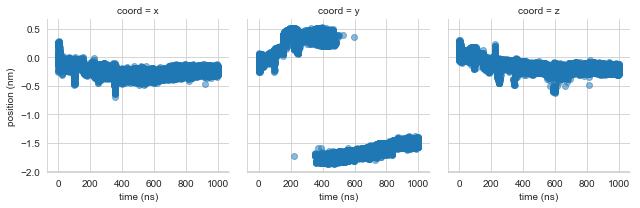

In [32]:
g = sns.FacetGrid(coor_melt.iloc[::100,:], col='coord')
g.map(plt.scatter, 't_ns', 'value', alpha=0.5)
g.set_axis_labels('time (ns)', 'position (nm)')

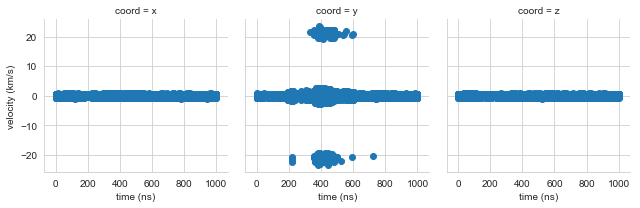

In [33]:
dt = df.loc[1, 't_ns']-df.loc[0, 't_ns']
vel = pd.DataFrame(df.iloc[1:, :3].values - df.iloc[:-1, :3].values, df.iloc[:-1, 3])
vel.columns=['x', 'y', 'z']
vel['t_ns'] = vel.index
vel.reset_index(drop=True, inplace=True)

vel_melt = pd.melt(frame=vel, id_vars=['t_ns'],  value_vars=['x', 'y', 'z'], var_name='coord')
vel_melt['value'] /= dt*1000
g = sns.FacetGrid(vel_melt.iloc[::100,:], col='coord')
g.map(plt.scatter, 't_ns', 'value')
g.set_axis_labels('time (ns)', 'velocity (km/s)')
plt.savefig('velocities-traj-4.png')

## Find transition region

Text(0.5,0,'time (ns)')

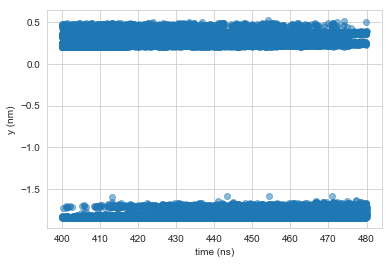

In [34]:
traj = df.loc[(df['t_ns']<480) & (df['t_ns'] > 400) , 'x':'t_ns'].values
dt = df.loc[1, 't_ns'] - df.loc[0, 't_ns']

plt.plot(traj[::10, -1], traj[::10, 1], lw=0, marker='o', alpha=0.5)
plt.ylabel('y (nm)')
plt.xlabel('time (ns)')

## Autocorrelation functions
### Velocity

In [35]:
vtraj = (traj[1:, :]-traj[0:-1,:])
vacf = td.acf(vtraj[:, 0:3])

Text(0,0.5,'v-v acf')

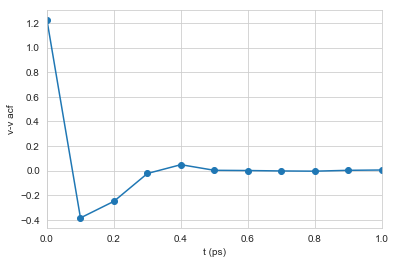

In [36]:
plt.plot(np.arange(vacf.shape[0])*dt*1000, vacf,  marker='o')
plt.xlim(-dt,1)
plt.xlabel('t (ps)')
plt.ylabel('v-v acf')


### Distance

Text(0,0.5,'r-r acf')

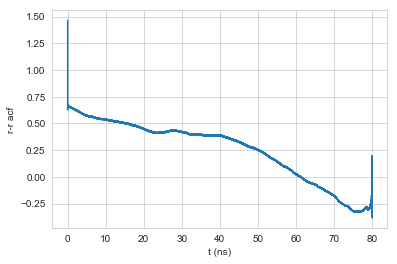

In [37]:
racf = td.acf(traj[:, 0:3])
plt.plot(np.arange(traj.shape[0])*dt, racf)
# plt.xlim(0,1)
plt.xlabel('t (ns)')
plt.ylabel('r-r acf')

Text(0,0.5,'r-r acf')

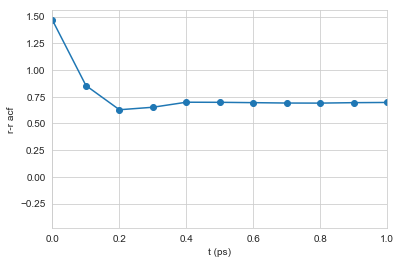

In [38]:
racf = td.acf(traj[:, 0:3])
plt.plot(np.arange(traj.shape[0])*dt*1000, racf, marker='o')
plt.xlim(-dt,1)
plt.xlabel('t (ps)')
plt.ylabel('r-r acf')

## Moving window histogram in fluctuating region

Text(0.5,0,'time (ns)')

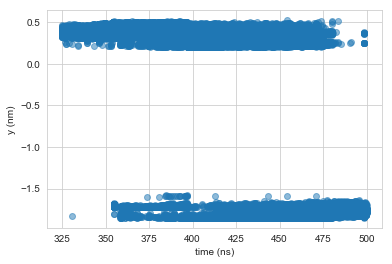

In [39]:
traj = df.loc[(df['t_ns']<500) & (df['t_ns'] > 325) , 'x':'t_ns'].values
dt = df.loc[1, 't_ns'] - df.loc[0, 't_ns']

plt.plot(traj[::10, -1], traj[::10, 1], lw=0, marker='o', alpha=0.5)
plt.ylabel('y (nm)')
plt.xlabel('time (ns)')

### Histogram window parameters

In [40]:

window = 2 # window size in ns
skip = 0.5 # skip in ns.  
nrows= int(window/dt)
nskip = int(skip/dt)
starts = np.arange(traj.shape[0])[::nskip]
print(len(starts))

350


### Histogram parameters

In [41]:

dr = 0.01 # histogram bin size in nm
ymin = np.min(traj[:,1])
ymax = np.max(traj[:,1])
r_tot = ymax-ymin
nbins = int(r_tot/dr)
bins = np.linspace(ymin, ymax, nbins)
print(nbins)
print(len(bins))

240
240


In [42]:
# for i, start in enumerate(starts):
#     counts, bins = np.histogram(traj[start:(start+nrows), 1], bins=bins)
#     F = -np.log(counts)
#     F[np.isinf(F)]=0
    
#     fig, axes = plt.subplots(2,1)
#     axes[0].scatter(traj[::1000, -1], traj[::1000, 1], alpha=0.1)
#     axes[0].scatter(traj[start:(start+nrows):1000, -1], 
#                     traj[start:(start+nrows):1000, 1], alpha=1)
#     axes[0].set_ylabel('y-coordinate (nm)')
#     axes[0].set_xlabel('time (ns)')
    
#     axes[1].plot(bins[:-1], F)
#     axes[1].set_xlim(ymin, ymax)
#     axes[1].set_ylim(-10, 0)
#     axes[1].set_xlabel('y-coordinate (nm)')
#     axes[1].set_ylabel('Free energy (kT)')
#     axes[1].set_title('{:4.2f}ns'.format(traj[start, -1]))
#     plt.tight_layout()
#     plt.savefig('histogram_animation/{:05d}.png'.format(i))
#     plt.close(fig)

In [43]:
# !convert -loop 0 -delay 1 histogram_animation/*.png out.gif

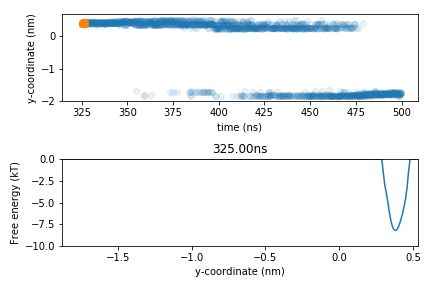

In [44]:
from IPython.display import Image
Image(filename='out.gif')

## Estimate MSM in the region 350 - 400

Text(0.5,0,'time (ns)')

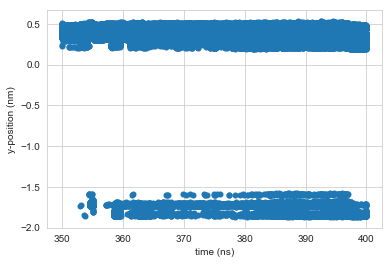

In [45]:
traj = df.loc[(df['t_ns']<400) & (df['t_ns'] > 350) , 'x':'t_ns'].values

plt.scatter(traj[:, -1], traj[:,1], lw=0.05, alpha=1, marker='o')
plt.ylabel('y-position (nm)')
plt.xlabel('time (ns)')

In [46]:
# Cluster
n_clusters = 100 #int(np.sqrt(traj.shape[0]))
clustering = coor.cluster_kmeans(traj[:,0:3],k=n_clusters, max_iter=100)

dtrajs = clustering.dtrajs


HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

In [47]:
its = msm.timescales_msm(dtrajs, 
                         np.logspace(0, 5, 100).astype(int), 
                         nits=5, n_jobs=-1)

HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

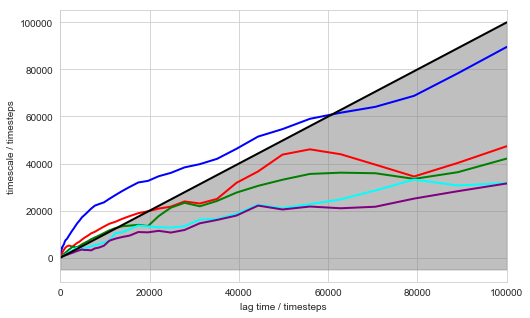

In [48]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
mplt.plot_implied_timescales(its, show_mean=False, ylog=False, units='timesteps', linewidth=2)
# plt.xlim(0, 200)
# plt.ylim(0, 5000)

/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


(1.0, 5000)

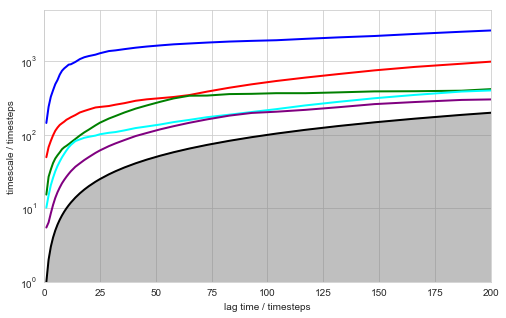

In [49]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
mplt.plot_implied_timescales(its, show_mean=False, ylog=True, units='timesteps', linewidth=2)
plt.xlim(0, 200)
plt.ylim(0, 5000)

In [50]:
M = msm.estimate_markov_model(dtrajs, lag=100)

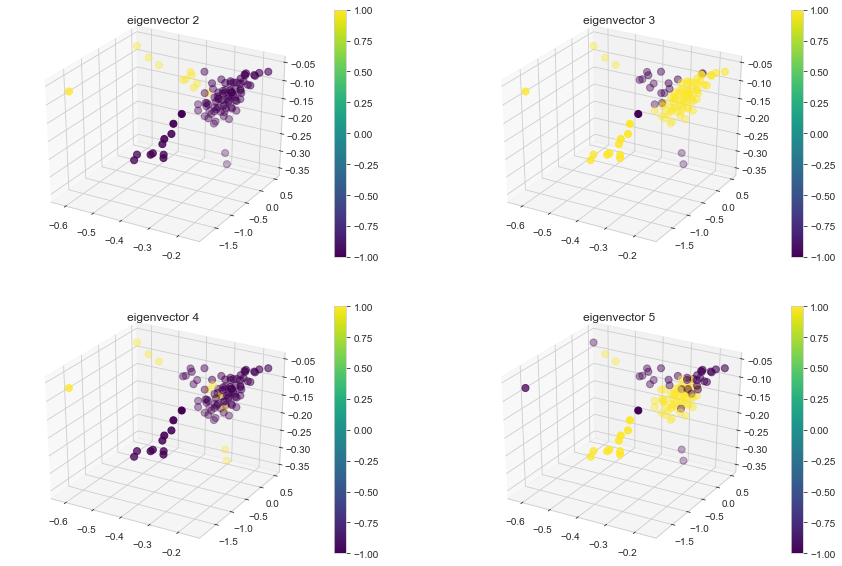

In [51]:
fig = plt.figure(figsize=(15,10))
for i in range(4):
    nvec = i+1
    ax = fig.add_subplot(2,2,i+1,projection='3d')

    c = ax.scatter(xs=clustering.clustercenters[:, 0], 
                   ys = clustering.clustercenters[:, 1], 
                   zs = clustering.clustercenters[:, 2], c=np.sign(M.eigenvectors_right()[:, nvec]), 
                   s=50, cmap='viridis')
    ax.set_title('eigenvector {}'.format(nvec+1))
    fig.colorbar(c)

## Estimate MSM in the region 400 - 450

Text(0.5,0,'time (ns)')

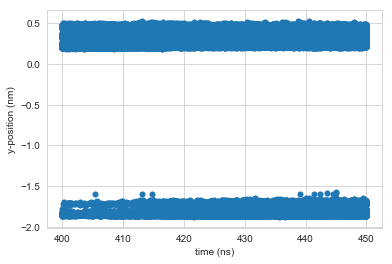

In [53]:
traj = df.loc[(df['t_ns']<450) & (df['t_ns'] > 400) , 'x':'t_ns'].values
plt.scatter(traj[:, -1], traj[:,1], lw=0.05, alpha=1, marker='o')
plt.ylabel('y-position (nm)')
plt.xlabel('time (ns)')

In [54]:
# Cluster
n_clusters = 100 #int(np.sqrt(traj.shape[0]))
clustering = coor.cluster_kmeans(traj[:,0:3],k=n_clusters, max_iter=100)

dtrajs = clustering.dtrajs


HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

In [55]:
its = msm.timescales_msm(dtrajs, 
                         np.logspace(0, 5, 100).astype(int), 
                         nits=5, n_jobs=-1)

HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

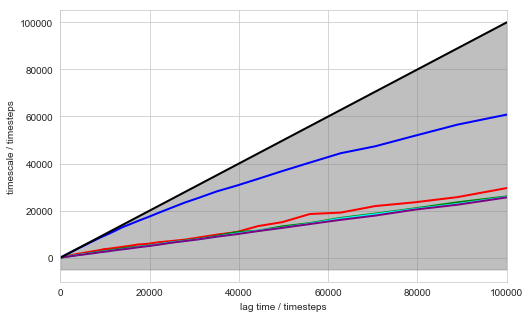

In [56]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
mplt.plot_implied_timescales(its, show_mean=False, ylog=False, units='timesteps', linewidth=2)
# plt.xlim(0, 200)
# plt.ylim(0, 5000)

/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_base.py:3291: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


(1.0, 5000)

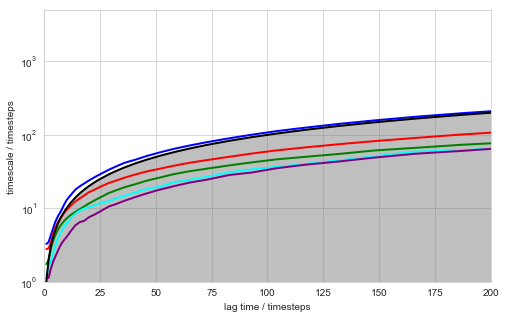

In [57]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
mplt.plot_implied_timescales(its, show_mean=False, ylog=True, units='timesteps', linewidth=2)
plt.xlim(0, 200)
plt.ylim(0, 5000)

In [58]:
M = msm.estimate_markov_model(dtrajs, lag=100)

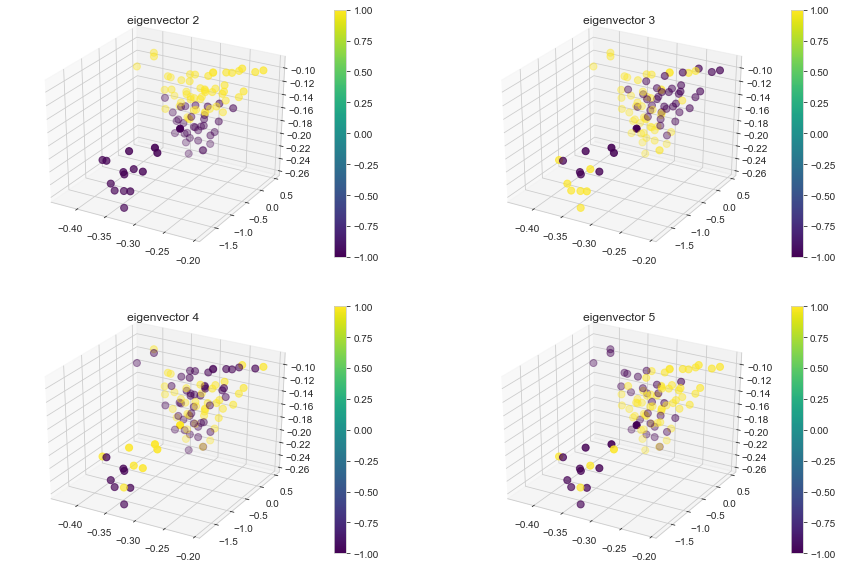

In [59]:
fig = plt.figure(figsize=(15,10))
for i in range(4):
    nvec = i+1
    ax = fig.add_subplot(2,2,i+1,projection='3d')

    c = ax.scatter(xs=clustering.clustercenters[:, 0], 
                   ys = clustering.clustercenters[:, 1], 
                   zs = clustering.clustercenters[:, 2], c=np.sign(M.eigenvectors_right()[:, nvec]), 
                   s=50, cmap='viridis')
    ax.set_title('eigenvector {}'.format(nvec+1))
    fig.colorbar(c)

Zoom in on trajectory

Text(0.5,0,'time (ns)')

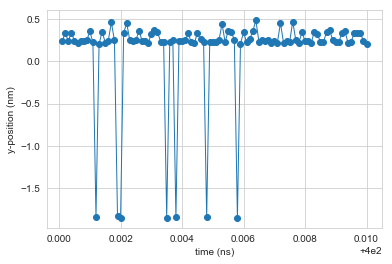

In [60]:
plt.plot(traj[:100, -1], traj[:100,1], lw=1, alpha=1, marker='o')
plt.ylabel('y-position (nm)')
plt.xlabel('time (ns)')

Text(0.5,0,'time (ns)')

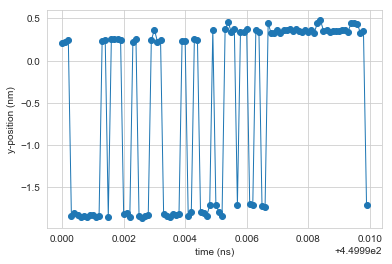

In [61]:
plt.plot(traj[-100:, -1], traj[-100:,1], lw=1, alpha=1, marker='o')
plt.ylabel('y-position (nm)')
plt.xlabel('time (ns)')

## Estimate MSM in the region 400 - 401ns

Text(0.5,0,'time (ns)')

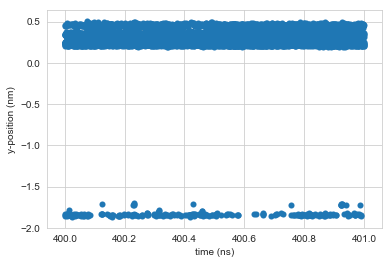

In [62]:
traj = df.loc[(df['t_ns']<401) & (df['t_ns'] > 400) , 'x':'t_ns'].values

plt.scatter(traj[:, -1], traj[:,1], lw=0.05, alpha=1, marker='o')
plt.ylabel('y-position (nm)')
plt.xlabel('time (ns)')

In [63]:
# Cluster
n_clusters = 100 #int(np.sqrt(traj.shape[0]))
clustering = coor.cluster_kmeans(traj[:,0:3],k=n_clusters, max_iter=100)

dtrajs = clustering.dtrajs


HBox(children=(HBox(children=(Label(value='initialize kmeans++ centers'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

HBox(children=(HBox(children=(Label(value='kmeans iterations'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

In [64]:
its = msm.timescales_msm(dtrajs, 
                         np.logspace(0, 3, 100).astype(int), 
                         nits=5, n_jobs=-1)

HBox(children=(HBox(children=(Label(value='estimating MaximumLikelihoodMSM'),), layout=Layout(max_width='35%', min_width='35%')), HBox(children=(IntProgress(value=0, layout=Layout(flex='2')), HTML(value='')), layout=Layout(padding='0 0 0 20px'))), layout=Layout(display='inline-flex', flex_flow='row wrap', width='100%'))

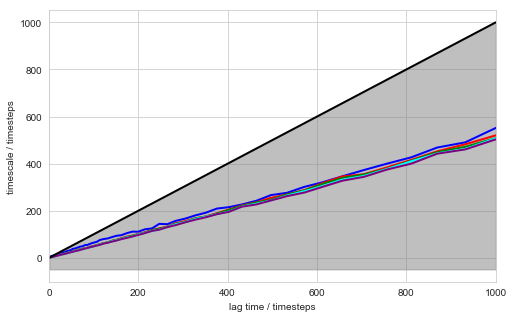

In [65]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
mplt.plot_implied_timescales(its, show_mean=False, ylog=False, units='timesteps', linewidth=2)
# plt.xlim(0, 200)
# plt.ylim(0, 5000)

(0, 10)

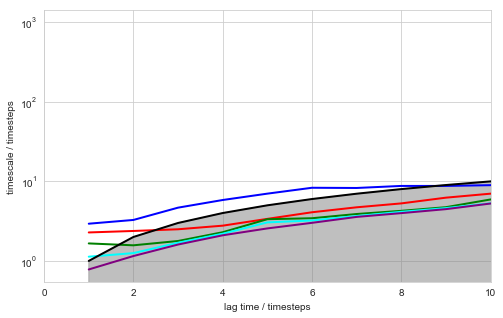

In [66]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))
mplt.plot_implied_timescales(its, show_mean=False, ylog=True, units='timesteps', linewidth=2)
plt.xlim(0, 10)


In [67]:
M = msm.estimate_markov_model(dtrajs, lag=4)

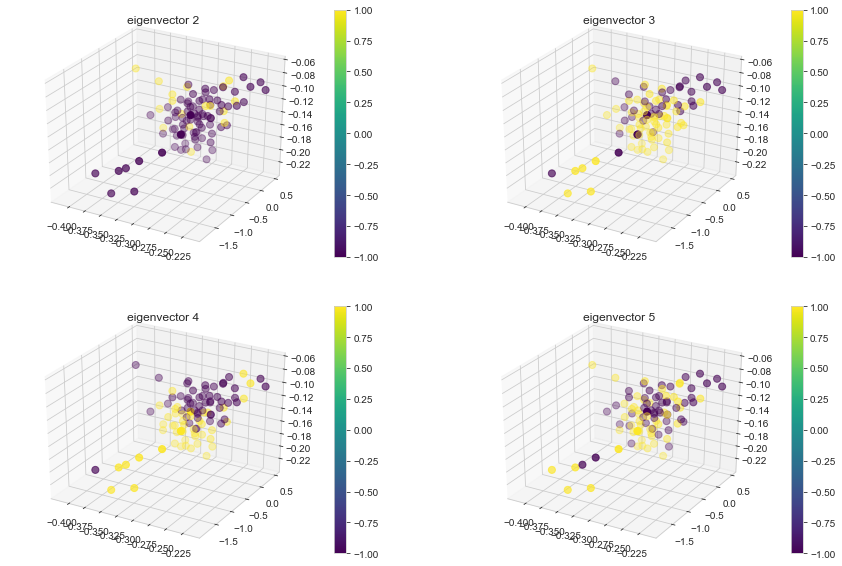

In [68]:
fig = plt.figure(figsize=(15,10))
for i in range(4):
    nvec = i+1
    ax = fig.add_subplot(2,2,i+1,projection='3d')

    c = ax.scatter(xs=clustering.clustercenters[:, 0], 
                   ys = clustering.clustercenters[:, 1], 
                   zs = clustering.clustercenters[:, 2], c=np.sign(M.eigenvectors_right()[:, nvec]), 
                   s=50, cmap='viridis')
    ax.set_title('eigenvector {}'.format(nvec+1))
    fig.colorbar(c)

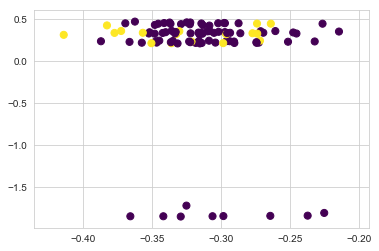

In [69]:
plt.scatter(clustering.clustercenters[:, 0], clustering.clustercenters[:, 1], 
           c=np.sign(M.eigenvectors_right()[:, 1]), s=50,cmap='viridis')

In [71]:
hmm = M.coarse_grain(2)

In [72]:
hmm.transition_matrix

array([[0.88502396, 0.11497604],
       [0.00142981, 0.99857019]])

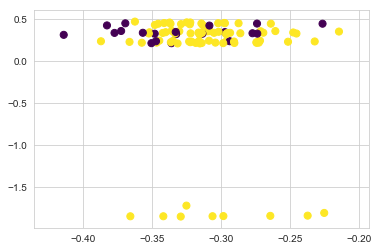

In [74]:
plt.scatter(clustering.clustercenters[:, 0], clustering.clustercenters[:, 1], 
           c=np.sign(hmm.metastable_assignments), s=50,cmap='viridis')